# Finding the closed-form solution for transition probabilities

Here we describe the process of finding all turning angle sequences and their accompanying volumes using a 2D example. 


### Finite directions represented in an ODF

Currently `MITTENS` requires that ODFs have values estimated for a set of pre-defined directions $\Theta$. Here we will use the `"odf4"` set of directions from DSI Studio. Here we select only directions that are in the axial plane, resulting in a set of directions in 2D:

Populating the interactive namespace from numpy and matplotlib


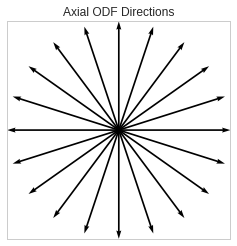

In [1]:
%pylab inline
from mittens.utils import *
odf_vertices, odf_faces = get_dsi_studio_ODF_geometry("odf4")

# select only the vertices in the x,y plane
ok_vertices = np.abs(odf_vertices[:,2]) < 0.01
odf_vertices = odf_vertices[ok_vertices]

def draw_vertex(ax, vertex, color="r"):
    ax.plot((0,vertex[0]), (0,vertex[1]), color=color,linewidth=3,alpha=0.6)

def draw_vertices(ax,selected_vertex=None,selected_vertex_color="r"):
    # Draws ODF Vertices on an axis object
    center = np.zeros(ok_vertices.sum())
    ax.quiver(center, center, odf_vertices[:,0], odf_vertices[:,1], 
              scale=1,angles="xy", scale_units="xy")
    ax.set_xlim(-1,1)
    ax.set_ylim(-1,1)
    ax.set_xticks([])
    ax.set_yticks([])
    
    if selected_vertex is not None:
        draw_vertex(ax,selected_vertex,color=selected_vertex_color)
    
# Plot them to make sure
fig,ax = plt.subplots(figsize=(4,4))
ax.set_title("Axial ODF Directions")
draw_vertices(ax);

In practice there will need to be diffusion magnitudes for each direction, $\bar{p}_u(\theta)$. Some packages such as MRTRIX do not evaluate ODFs on a fixed set of directions and instead store SH coefficients. These can be evaluated on a set of directions and used in `MITTENS`, but for this example we don't actually need these values. Instead, we leave the magnitudes out of this exercise and keep $\bar{p}_u(\theta)$ as a variable that will be filled in later with empirical values.

### Turning angle sequences

In order to calculate analytic transition probability from voxel $u$ to voxel $v$ we need to find the finite set of turning angle sequences that can make a final hop into $v$ from $u$ while obeying the geometric constraints. Then for each turning angle sequence $\sigma \in \mathit{\Sigma}$ we have to find the accompanying volume $\mathcal{V}(\sigma,v)$ where $\sigma$ could start such that it ends in $v$. Here we plot the 2D voxel grid with voxel $u$ in the center and potential voxel $v$'s numbered around it:

''

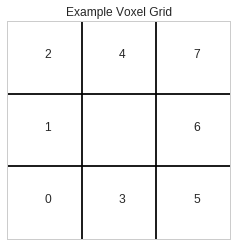

In [2]:
# Plot the voxel grid
def draw_grid(ax):
    
    for border in (0,1):
        ax.axhline(border,color="k")
        ax.axvline(border,color="k")
    ax.set_xlim(-1,2)
    ax.set_ylim(-1,2)
    ax.set_xticks([])
    ax.set_yticks([])

nfig,nax = plt.subplots(figsize=(4,4))
draw_grid(nax)
nax.set_title("Example Voxel Grid")
neighbors_coords = []
for xshift in (-1,0,1):
    for yshift in (-1,0,1):
        if not xshift == yshift == 0:
            neighbors_coords.append((xshift,yshift))

for neighbornum,neighbor in enumerate(neighbors_coords):
    nax.text(neighbor[0] + 0.5, neighbor[1] + 0.5, str(neighbornum))

;

Suppose we want to find the possible ways to get from center voxel $u$ to the right anterior neighbor $v$ (ie neighbor 7). We first need to define the geometric constraints. 
We make the following assumptions

 * Voxel edges are all fixed length. Here we use 1
 * Step size is a fixed length. Here we use 0.5
 * The maximum turning angle is 35 degrees

Now we can begin finding the turning angle sequences that can get from $u$ to $v$. This problem is solved recursively. Each step in the recursion requires a potential source rectangle, a desired target rectangle and step vector. The step vector is of our chosen fixed length in a direction available in $\Theta$. At each recursion it is determed whether a rectangle exists in the source rectangle where a step can be taken along the step vector such that it ends in the target rectangle. Below are some plotting functions and the function that will be called recursively (`get_area`):



In [3]:
def overlap(min1, max1, min2, max2):
    # Compares bounding coordinates of two rectangles
    return max(0, min(max1, max2) - max(min1, min2)), max(min1,min2), min(max1,max2)


def get_area(source_low_left, source_top_right, target_low_left,
                              target_top_right, direction):
    ''' 
    2D computation of the area in source rectangle from which a step of size STEPSIZE in
    direction will land in the target rectangle

    Parameters:
    ----------
    source_low_left:  tuple of lower, left coordinates of source rectangle
    source_top_right: tuple of upper, right coordinates of source rectangle

    target_low_left:  tuple of lower, left coordinates of target rectangle
    target_top_right: tuple of upper, right coordinates of target rectangle

    direction:tuple specifying the direction considered

    Returns: the area, (lower, left)- coordinates, (upper, right)-coordinates of the 
    area in the source rectangle from which a step of size STEPSIZE in the given direction 
    will land in the target rectangle
    '''
    
    x_min = target_low_left[0] - STEPSIZE*direction[0]
    x_max = target_top_right[0] - STEPSIZE*direction[0]
    
    x_delta,x_start,x_end = overlap(source_low_left[0],source_top_right[0],x_min,x_max)
    y_min = target_low_left[1] - STEPSIZE*direction[1]
    y_max = target_top_right[1] - STEPSIZE*direction[1]
    
    y_delta,y_start,y_end = overlap(source_low_left[1],source_top_right[1],y_min,y_max)
  
    return x_delta*y_delta, [x_start, y_start], [x_end,y_end]

# Some functions for plotting
from matplotlib import patches
def draw_square(lower_left, upper_right, ax, color, fill=True):
    ax.add_patch(
            patches.Rectangle(lower_left, upper_right[0]-lower_left[0],
                upper_right[1] - lower_left[1], alpha=1, color=color, fill=fill))



### One-hop turning angle sequences

We start with finding all 1-hop turning angle sequences from $u$ to $v$. All directions in $\Theta$ need to be tested. We will start with the sixth direction in $\Theta$, $\Theta[5]$ times the step size of 0.5 to create our first step vector. The first call to `get_area` will have the boundaries of center voxel $u$ as the source rectangle. The boundaries of the target voxel $v$ are target rectangle.

*Intuitively this step is solving the problem "If I seed somewhere in voxel $u$ and know I'm going to take direction $\Theta[5]$,  where can I land in voxel $u$ so that I'm going to end in voxel $v$?"*

Now we can call `get_area` after specifying the step size, turning angle max, and an initial direction

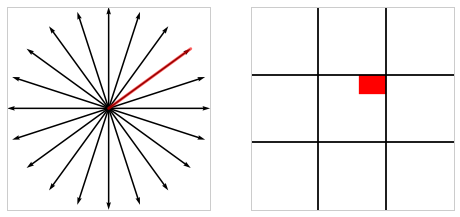

In [4]:
STEPSIZE=0.5 # choose the fixed step size
theta1 = odf_vertices[5] # Choose the 6th direction in Theta as an example
angle_max = 35 # in degrees

# For plotting
fig,(dax,vax) = plt.subplots(ncols=2,subplot_kw = {"aspect":"equal"})
draw_vertices(dax,theta1)
draw_grid(vax)

# Specift rectangle boundaries
v11 = (0,0) # Lower left of (0,0)
v12 = (1,1) # Upper right of (0,0)
v21 = (1,1) # Lower left of (1,1)
v22 = (2,2) # Upper right of (1,1)
area1,sq_bot1,sq_top1 = get_area(v11,v12,v21,v22,theta1)

draw_square(sq_bot1, sq_top1, vax, "r")


We have generated a turning angle sequence $\sigma_1=(\Theta[5])$ and calculated the volume from which this turning angle sequence could begin such that it ends in $v$ (it's stored in the `area1` variable, plotted as a red rectangle). 

This is the first equivalence class that we've found. In probabilistic simulations, the probability of landing *exactly* in the red square *and* randomly selecting $\Theta[5]$ is $\bar{p}_u(\Theta[5])\mathcal{V}(\sigma_1,v)$. Or, more concretely, it would be `area1*odf_magnitudes[5]` if the ODF magnitudes were stored in an array called `odf_magnitudes`. 

Recall that the analytic transition probability from $u$ to $v$ is

$$\text{P}(u \rightarrow v) = \sum_{\sigma \in \mathit{\Sigma}}\text{P}_u(\sigma) \mathcal{V}( \sigma, v ) $$

You can directly calculate the probability of this one-hop turning angle sequence by

```python
prob_sigma1 = area1 * odf_magnitudes[5]
```


## Two-hop turning angle sequences

Now that we have a one-hop turning angle sequence and its corresponding $\mathcal{V}$, we can loop over other directions in $\Theta$ to see which could be taken *into* the red area. For example, suppose the loop has made it to $\Theta[1]$.  We again call `get_area`, but this time the target rectangle is the red rectangle from the previous step.

Here we plot the two directions in a new turning angle sequence $\sigma_2=(\Theta[1],\Theta[5])$ and $\mathcal{V}(\sigma_2, v)$ is drawn in blue:

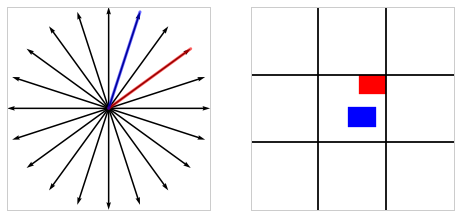

In [5]:
# try a theta2
theta2 = odf_vertices[1]
fig,(dax1,vax1) = plt.subplots(ncols=2,subplot_kw = {"aspect":"equal"})
draw_vertices(dax1, theta1,selected_vertex_color="r")
draw_vertex(dax1,theta2,color="b")
draw_grid(vax1)
draw_square(sq_bot1,sq_top1, vax1, "r")

area2,sq_bot2,sq_top2 = get_area(v11,v12,sq_bot1,sq_top1,theta2)
draw_square(sq_bot2,sq_top2, vax1, "b")


Thinking back to probabilistic simulations, we need to calculate the probability of landing in the blue rectangle *and* randomly selecting $\Theta[1]$ *and then* randomly selecting $\Theta[5]$ from directions compatible with direction $\Theta[1]$. 

The probability of landing in the blue rectangle is $\mathcal{V}(\sigma_2,v)$, which is stored in the `area2` variable. There is no constraint on the first step, which is randomly selected from all the directions in $\Theta$. The probability is then simply $\bar{p}_u(\Theta[1])$, or `odf_magnitudes[1]`. The next step is not as simple because the maximum turning angle parameter comes into play. The next step isn't randomly selected from all the directions in $\Theta$, but only those who create an angle less than the maximum turning angle with the previous step. Suppose only directions 0-9 are compatible with $\Theta[5]$. The conditional probability $\text{P}(\Theta[5] \mid \Theta[1])$, or `odf_magnitudes[5]/odf_magnitudes[:10].sum()`. You can directly calculate the probability of this two-hop turning angle sequence by

```python
prob_sigma2 = area2 * odf_magnitudes[1] * odf_magnitudes[5]/odf_magnitudes[:10].sum()
```


### Three-hop turning angle sequences

The process again proceeds to loop over all directions in $\Theta$ to see which could end in the blue rectangle while still starting in the center voxel $u$ (while forming an allowable angle with the previous step). Suppose the loop has made it to direction $\Theta[7]$. The call to `get_area` will now use the blue rectangle as the target. This three-hop turning angle sequence is $\sigma_3=\left(\Theta[7],\Theta[1],\Theta[5]\right)$

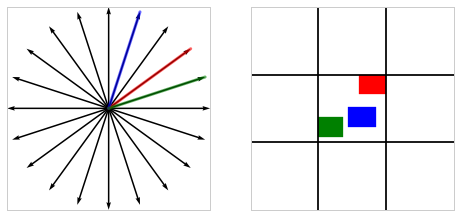

In [6]:
# try a theta3
theta3 = odf_vertices[7]
fig,(dax2,vax2) = plt.subplots(ncols=2,subplot_kw = {"aspect":"equal"})

draw_vertices(dax2, theta1,selected_vertex_color="r")
draw_vertex(dax2,theta2,color="b")
draw_vertex(dax2,theta3,color="g")

draw_grid(vax2)
draw_square(sq_bot1, sq_top1, vax2, "r")
draw_square(sq_bot2, sq_top2, vax2, "b")

area3, sq_bot3,sq_top3 = get_area(v11,v12,sq_bot2,sq_top2,theta3)
draw_square(sq_bot3, sq_top3, vax2, "g")

Here the area $\mathcal{V}(\sigma_3,v)$ is drawn as a green rectangle and stored in variable `area3`. Again thinking back to probabilistic simulations, we need to calculate the probability of landing in the green rectangle *and* randomly selecting $\Theta[7]$ *and then* randomly selecting $\Theta[1]$ from directions compatible with $\Theta[7]$ *and then* randomly selecting $\Theta[5]$ from directions compatible with $\Theta[1]$. 

The probability of landing in the green rectangle is $\mathcal{V}(\sigma_3,v)$, which is stored in the `area3` variable. There is no constraint on the first step, which is randomly selected from all the directions in $\Theta$, so the probability is $\bar{p}_u(\Theta[7])$, or `odf_magnitudes[7]`. If directions 3-12 are compatible with $\Theta[7]$, the conditional probability of the next step is $\text{P}(\Theta[1] \mid \Theta[7])$, or `odf_magnitudes[1]/odf_magnitudes[3:13].sum()`. Finally the probability of the final step is $\text{P}(\Theta[5] \mid \Theta[1])$, or `odf_magnitudes[5]/odf_magnitudes[:10].sum()`. You can directly calculate the probability of this three-hop turning angle sequence by

```python
prob_sigma3 = area3 * odf_magnitudes[7] * odf_magnitudes[1]/odf_magnitudes[3:13].sum() \
                * odf_magnitudes[5]/odf_magnitudes[:10].sum()
```


### N-hop turning angle sequences

This process continues until there are no more compatible prior hops in center voxel $u$. Once all possibilities are exhausted the entire sum is written as a Fortran function that takes the `odf_magnitudes` array is its input. This Fortran code is compiled, a numpy extension is built with `f2py`, then the function is called from inside the `mittens.MITTENS` class.

# A complete example

The code below is *not* the code used within `MITTENS`, but is useful to show how the algorithm would operate in 2D on up to three-step turning angle sequences. No probabilities are actually calculated here. One-hop areas are outlined in red, two-hop areas are blue and three-hop areas are green.

In [7]:
from mittens.utils import angle_between, pairwise_distances
import numpy as np

angle_max = 35
# Pre-calculate compatible angles
compatible_angles = pairwise_distances(odf_vertices,metric=angle_between) < angle_max
compatible_vertex_indices = np.array([np.flatnonzero(r) for r in compatible_angles])

def draw_square(lower_left, upper_right, ax, color):

    ax.add_patch(
            patches.Rectangle(lower_left, upper_right[0]-lower_left[0],
                upper_right[1] - lower_left[1], alpha=0.1, fc=color,
                              fill=True))
    ax.add_patch(
            patches.Rectangle(lower_left, upper_right[0]-lower_left[0],
                upper_right[1] - lower_left[1], alpha=1,lw=2,ec=color,
                              fill=False))
    
def solve_for_neighbor(neighbor_min, neighbor_max):
    center_min, center_max = [0,0], [1,1]
    fig, axc = plt.subplots(subplot_kw = {"aspect":"equal"}, figsize=(6,6))
    
    # Which vertices exit into the target?
    exits = np.array([
            get_area(center_min, center_max, neighbor_min, neighbor_max, v)[0] > 0 \
               for v in odf_vertices ])
    
    for t1_num in np.flatnonzero(exits):
        theta1 = odf_vertices[t1_num]
        area1, sq_bot1, sq_top1 = get_area(center_min,center_max, 
                                        neighbor_min, neighbor_max, theta1)
        draw_square(sq_bot1, sq_top1, axc, "r")
        possible_theta2s = compatible_vertex_indices[t1_num]
        
        for t2_num in possible_theta2s:
            theta2 = odf_vertices[t2_num]
            area2, sq_bot2, sq_top2 = get_area(center_min,center_max, 
                                                    sq_bot1,sq_top1, theta2)
            if area2 == 0:
                continue
                
            draw_square(sq_bot2, sq_top2, axc, "b")
            possible_theta3s = compatible_vertex_indices[t2_num]
            
            for t3_num in possible_theta3s:
                theta3 = odf_vertices[t3_num]
                area3, sq_bot3, sq_top3 = get_area(center_min,center_max, 
                                                        sq_bot2,sq_top2, theta3)
                if area3 == 0:
                    continue
                draw_square(sq_bot3, sq_top3, axc, "g")



    draw_grid(axc)
    axc.set_xlim(-0.1,1.1)
    axc.set_ylim(-0.1,1.1)


## Right neighbor

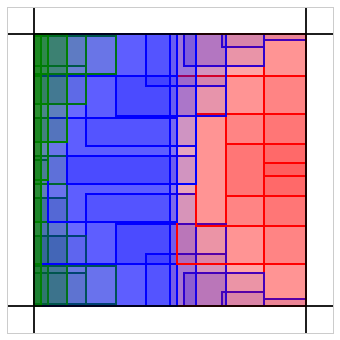

In [8]:
solve_for_neighbor([1,0],[2,1])

## Right Anterior Neighbor

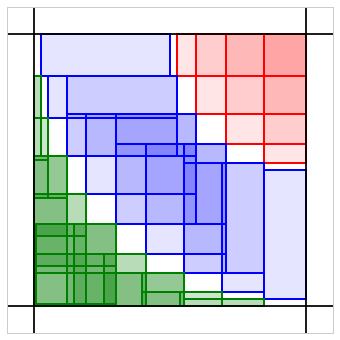

In [9]:
solve_for_neighbor([1,1],[2,2])

## Anterior Neighbor

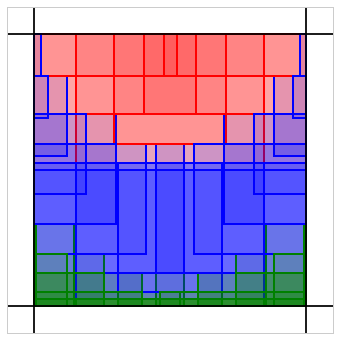

In [10]:
solve_for_neighbor([0,1],[1,2])

## Left Anterior Neighbor

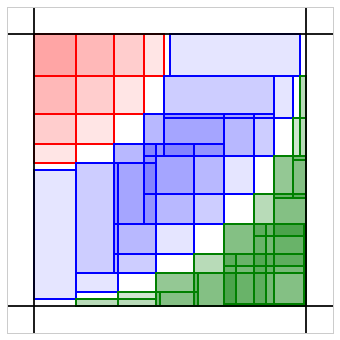

In [11]:
solve_for_neighbor([-1,1],[0,2])

## Left Neighbor

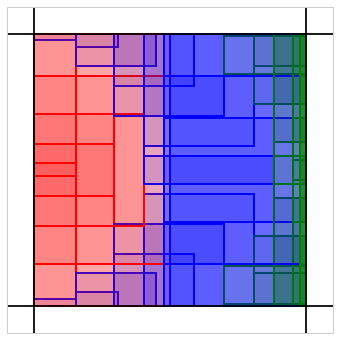

In [12]:
solve_for_neighbor([-1,0],[0,1])

## Left Posterior Neighbor

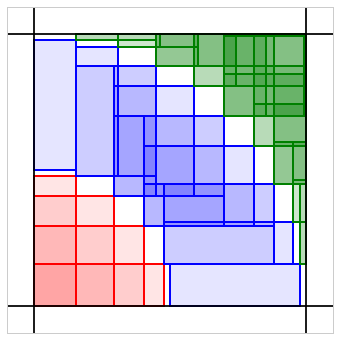

In [13]:
solve_for_neighbor([-1,-1],[0,0])

## Posterior Neighbor

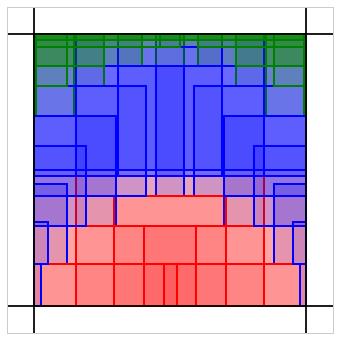

In [14]:
solve_for_neighbor([0,-1],[1,0])

## Right Posterior Neighbor

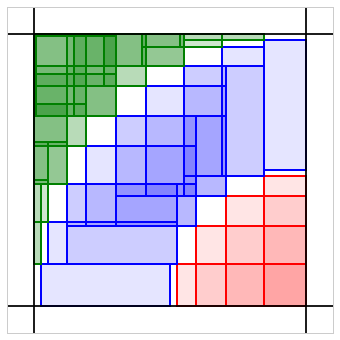

In [15]:
solve_for_neighbor([1,-1],[2,0])